In [25]:
from medmnist import DermaMNIST
import numpy as np
import pandas as pd
import torchvision.transforms as transforms

data_transform = transforms.Compose([ # create transformation steps
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize(mean=[.5], std=[.5]) # normalize tensor by rescaling
])

train_dataset = DermaMNIST(split="train", download=True, transform=data_transform) # testing dataset transformed using above transformations
test_dataset = DermaMNIST(split="test", download=True, transform=data_transform) # training dataset transformed using above transformations

Using downloaded and verified file: C:\Users\wammi\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\wammi\.medmnist\dermamnist.npz


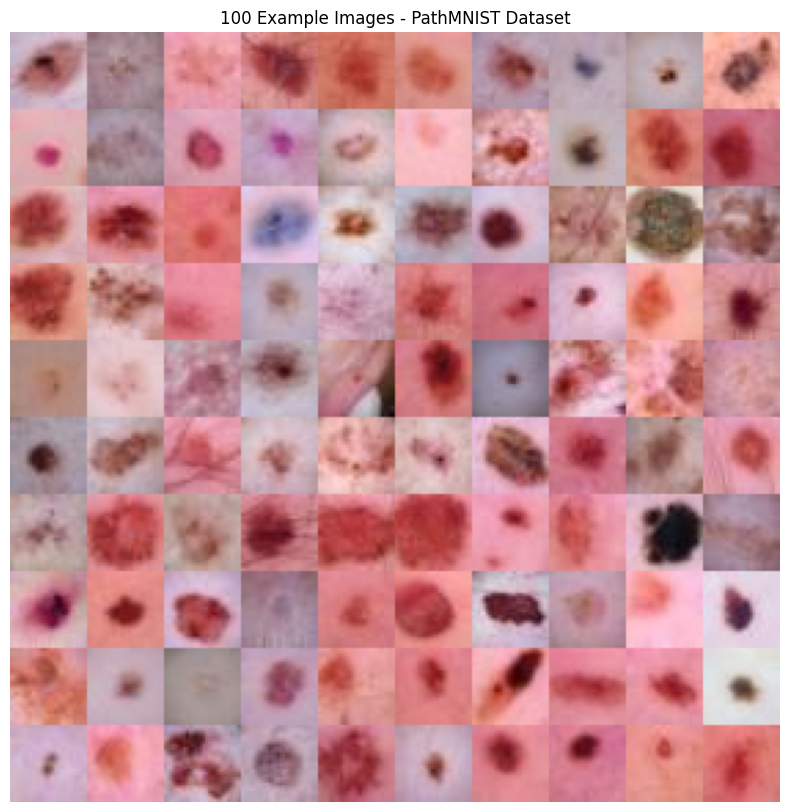

In [26]:
import numpy as np
import matplotlib.pyplot as plt

montage_img = train_dataset.montage(length=10) # create 10x10 grid of 100 images

plt.figure(figsize=(10, 10)) # set figure size to 10 by 10
plt.imshow(montage_img) # show image
plt.axis('off') # no graph axes
plt.title('100 Example Images - PathMNIST Dataset') # title plot
plt.show()# show plot

In [27]:
img, _ = train_dataset[0] # extract image shape from single item in train_dataset
print("Image Shape: " , img.shape) # output shape of image

print("Train dataset size: ", len(train_dataset)) # output how big train dataset is
print("Test dataset size: ", len(test_dataset)) # output how big test dataset is

print(train_dataset) # print summary of train_dataset for label information

Image Shape:  torch.Size([3, 28, 28])
Train dataset size:  7007
Test dataset size:  2005
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: C:\Users\wammi\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.


In [28]:
import pandas as pd

labels = { # initialize dictionary with labels and 0 for count
    0:0, 
    1:0,
    2:0,
    3:0,
    4:0,
    4:0,
    5:0,
    6:0
}

for _, label in train_dataset: # loop through each image in training dataset
    label = int(label) # change label from tensor to int
    if label in labels: # check if label in dictionary
        labels[label] += 1 # if in dictionary, add 1
    else: # if label not in dictionary
        labels[label] = 1 # if not in dictionary, add to dictionary with count 0
        
names = { # dictionary of label number and corresponding label name
    0: 'actinic keratoses and intraepithelial carcinoma',
    1: 'basal cell carcinoma',
    2: 'benign keratosis-like lesions',
    3: 'dermatofibroma',
    4: 'melanoma',
    5: 'melanocytic nevi',
    6: 'vascular lesions'
}

df = pd.DataFrame([ # convert dictionary to pandas dataframe
    {
        "Class Name": names[i], # get label name from number
        "Prevalence (%)": round(100 * labels[i] / sum(labels.values()), 2) # calculate prevalence
    }
    for i in sorted(labels.keys()) # sort in order of labels numbers
])

print(df) # output table


C:\Users\wammi\AppData\Local\Temp\ipykernel_54584\3995716338.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # change label from tensor to int


                                        Class Name  Prevalence (%)
0  actinic keratoses and intraepithelial carcinoma            3.25
1                             basal cell carcinoma            5.12
2                    benign keratosis-like lesions           10.97
3                                   dermatofibroma            1.14
4                                         melanoma           11.12
5                                 melanocytic nevi           66.98
6                                 vascular lesions            1.41


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): # create new class
    '''
    Creates a convolutional neural network.
    '''
    def __init__(self, in_channels=3, num_classes=9): # create initialization function
        '''
        intiialize with channels and number of classes
        '''
        super(CNN, self).__init__() # intialize parent class

        # layer 1
        self.layer1 = nn.Sequential( # sequential neural network structure
            nn.Conv2d(in_channels, 16, kernel_size=3), # increase from 3 to 16 channels
            nn.BatchNorm2d(16), # normalization applied in batches
            nn.ReLU() # relu activation function
        )

        # layer 2
        self.layer2 = nn.Sequential( # sequential neural network structure
            nn.Conv2d(16, 16, kernel_size=3), # apply 3x3 convolution with 16 channels still
            nn.BatchNorm2d(16), # normalization applied in batches
            nn.ReLU(), # relu activation function
            nn.MaxPool2d(kernel_size=2, stride=2) # pooling layer with stride window of 2
        )

        # layer 3
        self.layer3 = nn.Sequential( # sequential neural network structure
            nn.Conv2d(16, 64, kernel_size=3), # increase channels from 16 to 64
            nn.BatchNorm2d(64), # normalization applied in batches
            nn.ReLU() # relu activation function
        )

        # layer 4
        self.layer4 = nn.Sequential( # sequential neural network structure
            nn.Conv2d(64, 64, kernel_size=3), # apply 3x3 convolution maintaining 64 channels
            nn.BatchNorm2d(64), # normalization applied in batches
            nn.ReLU(), # relu activation function
            nn.MaxPool2d(kernel_size=2, stride=2) # pooling layer with stride window of 2
        )

        # fully connected layer
        self.fc = nn.Sequential( # sequential neural network structure
            nn.Linear(64 * 4 * 4, 128), # flatten to 64 x 4 x 4
            nn.ReLU(), # relu activation function
            nn.Linear(128, 128), # maintain input/output size 128
            nn.ReLU(), # relu activation function
            nn.Linear(128, num_classes) # final output of number of classes
        )

    def forward(self, x):
        '''
        Defines how model steps through layers of convolutional neural network and returns output data
        '''
        x = self.layer1(x) # apply layer 1
        x = self.layer2(x) # apply layer 2
        x = self.layer3(x) # apply layer 3
        x = self.layer4(x) # apply layer 4
        x = x.view(x.size(0), -1)  # flatten from 4D to 2D
        x = self.fc(x) # apply final layer that outputs correct output dimensions
        return x # return final predicted output

model = CNN(in_channels=3, num_classes=7) # initailize CNN model


In [37]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss() # set loss function as cross entropy loss

In [44]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

batch_size = 100  # num of samples per mini-batch

train_loader = DataLoader( # load in testing dataset
    train_dataset, # load training dataset
    batch_size=batch_size, # mini-batch size
    shuffle=True # shuffle the data at every epoch
)

test_loader = DataLoader( # load in testing dataset
    test_dataset,  # the testing dataset from PathMNIST
    batch_size=batch_size, # same mini-batch size
    shuffle=False # no need to shuffle during testing
)

learning_rate = 0.01 # set learning rate to 0.01


optimizer = optim.SGD( # stochastic gradient descent optimizer
    model.parameters(), # pass the parameters of the CNN model as done above
    lr=learning_rate # learning rate of 0.01
)


loss: 1.068623  [    0/ 7007]
loss: 2.536233  [    0/ 7007]
loss: 0.570705  [    0/ 7007]
loss: 0.352319  [    0/ 7007]
loss: 1.874839  [    0/ 7007]
loss: 0.620793  [    0/ 7007]
loss: 0.818378  [    0/ 7007]
loss: 0.960926  [    0/ 7007]
loss: 0.075762  [    0/ 7007]
loss: 0.083461  [    0/ 7007]


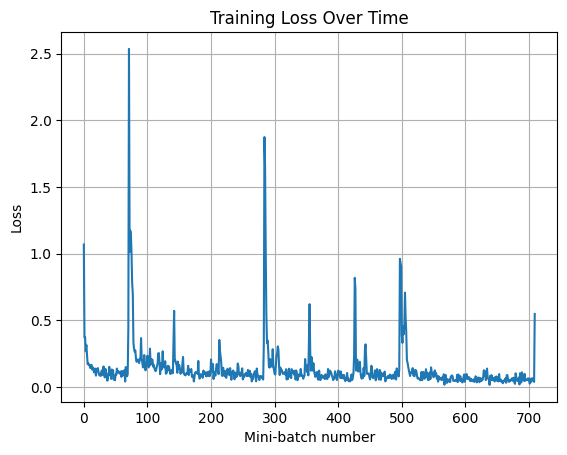

In [45]:
# Define training loop function
def train_loop(dataloader, model, loss_fn, optimizer):
    '''
    Trains the model based on data for 10 epochs. 
    Takes in dataloader, model, a loss function, and an optimizer. 
    '''
    #size = len(dataloader.dataset) # set the size
    model.train() # set the model to training mode
    all_losses = [] # save all losses

    
    for batch, (X,y) in enumerate(dataloader): # for each in dataloader, extract batch and (x,y)

        y = y.squeeze(1).long() # dimension is [100, 1], so convert to just 100 to make 1D

        pred = model(X) # make prediction with model

        loss = loss_fn(pred, y) # calculate loss

        loss.backward() # compute gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # reset gradients

        all_losses.append(loss.item()) # save loss in list

        if batch % 100 == 0:
            current = batch * len(X) # save current batch
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]") # print loss every 100 batches

    return all_losses # return loss list

epochs = 10 # train 10 epochs
all_losses = [] # save losses in list

for t in range(epochs): # for each epoch
    epoch_losses = train_loop(train_loader, model, criterion, optimizer) # train and get loss list
    all_losses += epoch_losses  # collect all mini-batch losses # put current epoch's losses in list

# Plot training loss over all mini-batches
plt.plot(all_losses) # plot giant list of all losses
plt.xlabel("Mini-batch number") # label x axis
plt.ylabel("Loss") # label y axis
plt.title("Training Loss Over Time") # title plot
plt.grid(True) # have grid lines in plot
plt.show() # disply plot


In [46]:
from medmnist import Evaluator
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_auc_score
import numpy as np

def getAUC(y_true, y_score, task=None):
    auc = 0.0
    valid_class_count = 0

    for i in range(y_score.shape[1]):
        y_true_binary = (y_true == i).astype(float)
        y_score_binary = y_score[:, i]

        if len(np.unique(y_true_binary)) < 2:
            continue

        auc += roc_auc_score(y_true_binary, y_score_binary)
        valid_class_count += 1

    if valid_class_count == 0:
        return 0.0
    return auc / valid_class_count


def test(data_loader, split): 
    '''
    Evaluates the model on the test data and returns the test accuracy and one-vs-rest AUC.
    Takes in the data_loader and what subset of data evaluating on (split)
    '''
    model.eval() # set in evaluation mode
    y_true = torch.tensor([]) # initialize tensor for true values
    y_score = torch.tensor([]) # initialize tensor for predicted scores
    #data_loader = train_loader_at_eval if split == 'train' else test_loader


    with torch.no_grad(): # with no gradient descent calculations
        for inputs, targets in data_loader: # loop through batches in data_loader
            outputs = model(inputs) # compute predictionary for inputs

            targets = targets.to(torch.float32) # conver to float to calculate metrics
            outputs = outputs.softmax(dim=-1) # convert to class probabilities

            y_true = torch.cat((y_true, targets), 0) # add to accumulated true values
            y_score = torch.cat((y_score, outputs), 0) # add to accumulated predicted score values
            
        
        y_true = y_true.numpy() # convert to numpy arrray
        y_score = y_score.detach().numpy() # detach from graph and convert to numpy

        auc = getAUC(y_true, y_score, 'multi-class')
        print(auc)
        
data_flag = "dermamnist" # which dataset are we working with

test(test_loader, "test") # run test function


0.7295590943245419
